<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Diffusion equation

In this project we will use several methods to solve the diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

This project consists of two notebooks. First, in this notebook, we will solve this equation using second order finite differences to approximate the $x$-derivatives, and we will use both the explict Euler and Crank-Nicolson timestepping methods.

In the second notebook for this project, we will learn how to use Dedalus to solve the same problem using spectral methods.

The objective for this notebook is learn about spatial discretization and to compare the stability, accuracy, and speed of the Explicit euler and Crank-Nicolson methods when applied to the diffusion equation.

Student tasks are in [Section 2.1](#section2pt1) and [Section 2.2](#section2pt2).

Before we start, load in the required libraries

In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

#Test message 2


Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [2]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Builds a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed
    M = sp.csr_matrix(M)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    #print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [3]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # build a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed:
    M = sp.csr_matrix(M)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    #print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [4]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [5]:
# Defining parameters
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 200

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

dx=(x_end-x_start)/(Nx-1)
dt=(t_end-t_start)/(Nt-1)

Run each method once:

In [6]:
# Run the simulations
print(f"CFL:{(kappa*dt)/dx**2}"); #Want to be analytical threshold, here is 1/2
c_EE = EE(x, t, kappa) # Explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

CFL:0.0991016016016016


/Users/nick/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:395: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/Users/nick/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:285: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


and finally, plot the results side-by-side

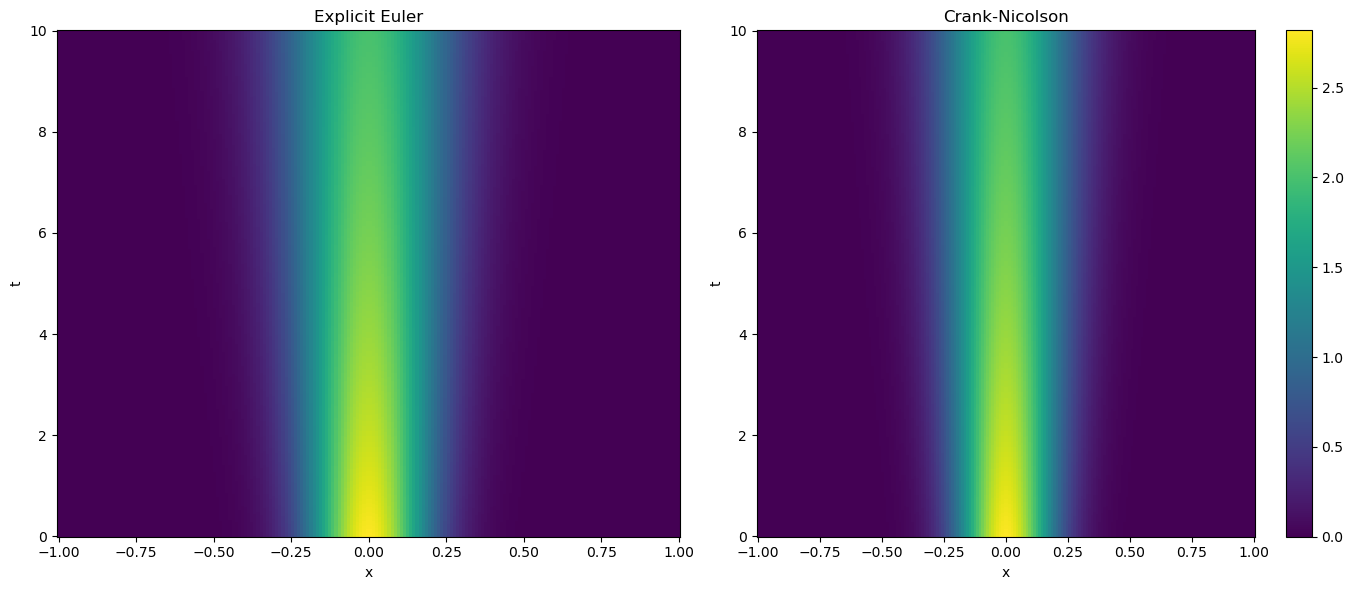

In [7]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
pcm1 = plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
#plt.colorbar(pcm1)
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
pcm2 = plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.colorbar(pcm2, ax=plt.gca())

plt.tight_layout()
plt.show()

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have very different stability properties. To explore this, try increasing the timestep (reduce the number of timesteps) and/or increase the diffusivity ($\kappa$) and see how each method responds. How does the stability depend on `Nx`? Discuss your findings below (~1 paragraph)



Stability:
For larger timesteps, both methods display poor resolutions but are not unstable.

For larger values of $\kappa$, Explicit Euler method becomes unstable, with values of 0.1 too high (*checkthis)

Dependence on Nx: Explicit Euler also breaks down for large Nx (>500)



### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

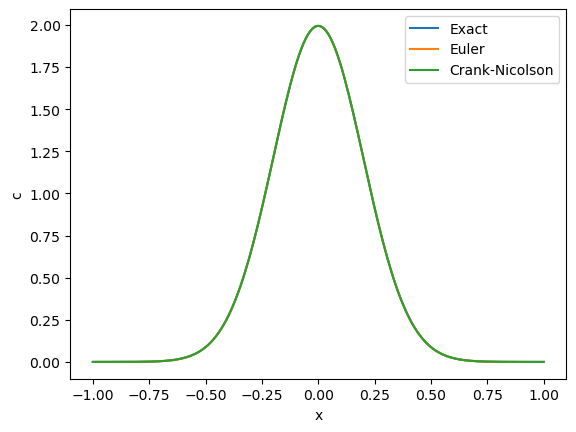

In [8]:
# Add code to plot exact and numerical solutions

def diff_exact(x, kappa, t):
    return (4*np.pi*kappa*t)**(-0.5)*np.exp(-x**2 / (4*kappa*t))


plt.plot(x, diff_exact(x, kappa, 20), label='Exact') #taking t=20 as then all methods will be evaluated at the same t
plt.plot(x, c_EE[:, -1], label='Euler')
plt.plot(x, c_CN[:, -1], label='Crank-Nicolson')
plt.xlabel('x')
plt.ylabel('c')
plt.legend()
plt.show()

Now, define a measure of the error of each numerical method compared to the exact solution (there is no single correct way to do this). Plot the error of both methods as a function of the grid spacing $\Delta x$. Then, similarly plot the error as a function of the timestep, $\Delta t$.

**To begin, choosing to examine error in C values across x at final timestep. The absolute value of error (|exact - numerical|) will be computed at each x value and summed over the full range of x (essentially taking the area between the curves). This is then iterated over a range of timesteps/ grid spacings to give error as a function of Δx or Δt**



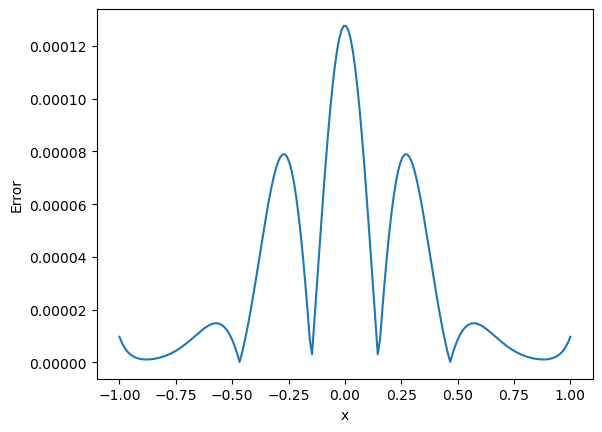

0.006032062330910547


In [9]:
mismatch_EE = diff_exact(x, kappa, 20) - c_EE[:, -1]
#plt.plot(x,mismatch_EE)
abs_diff_EE = np.zeros(len(x))
for j in range(len(x)):
    abs_diff_EE[j] = np.abs(mismatch_EE[j])

plt.plot(x,abs_diff_EE)
plt.xlabel('x')
plt.ylabel('Error')
plt.show()

a=np.sum(abs_diff_EE)
print(a)

In [10]:
#Attempt 1:
#Define arrays that will contain summed values for the absolute error for a given Nx
total_diff_EE = []
total_diff_CN = []

Nrange = np.arange(5,401,5)
for i in (Nrange): #Range of Nx to test
  Nx=i
  #Redefine and rerun functions
  t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
  x = np.linspace(x_start, x_end, Nx)  # Create a vector for x
  c_EE = EE(x, t, kappa); # explicit Euler
  c_CN = CN(x, t, kappa); # Crank-Nicolson

  abs_diff_EE = np.zeros(len(x)) #List for abs difference between exact and EE
  abs_diff_CN = np.zeros(len(x))

  mismatch_EE = diff_exact(x, kappa, 20) - c_EE[:, -1] #Getting difference of exact & numerical as f(x)
  mismatch_CN = diff_exact(x, kappa, 20) - c_CN[:, -1]

  for j in range(len(x)):
    abs_diff_EE[j] = np.abs(mismatch_EE[j])
    abs_diff_CN[j] = np.abs(mismatch_CN[j])
  #Sum these values to give total error for specific grid spacing and add them as a corresponding element
  total_diff_EE = np.append(total_diff_EE, np.sum(abs_diff_EE))
  total_diff_CN = np.append(total_diff_CN, np.sum(abs_diff_CN))

#Now take error averaged over number of gridspaces
error_EE = total_diff_EE
error_CN = total_diff_CN

sum_error_EE = np.sum(error_EE/len(np.arange(5,401,5)))
sum_error_CN = np.sum(error_CN/len(np.arange(5,401,5)))
print(sum_error_EE)
print(sum_error_CN)

error_in_EE = np.abs(c_EE[:,-1]-diff_exact(x,kappa,20))
print(np.sum(error_in_EE)/Nx)


0.03499647559637106
0.039858214669431895
2.5681779389004643e-05


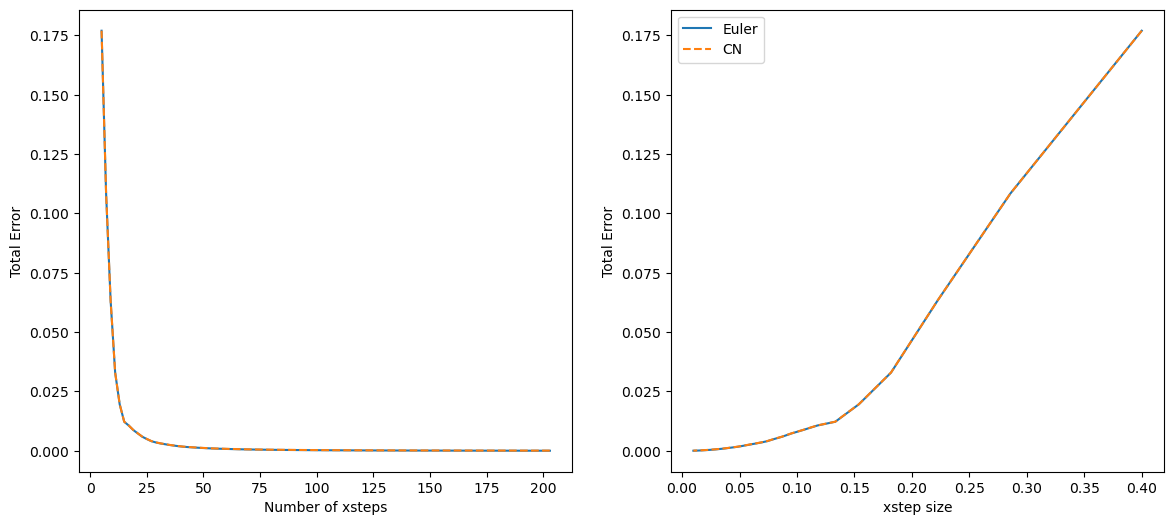

In [11]:
#Attempt 2
#Define arrays that will contain summed values for the absolute error for a given Nx
error_EE = []
error_CN = []

Nrange = np.arange(5,205,2)
for i in (Nrange): #Range of Nx to test
  Nx=i
  #Redefine and rerun functions
  t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
  x = np.linspace(x_start, x_end, Nx)  # Create a vector for x
  c_EE = EE(x, t, kappa); # explicit Euler
  c_CN = CN(x, t, kappa); # Crank-Nicolson

  abs_diff_EE = np.abs(diff_exact(x,kappa,20)-c_EE[:,-1]) #Getting absolute difference of exact & numerical as f(x)
  abs_diff_CN = np.abs(diff_exact(x,kappa,20)-c_CN[:,-1])

  #Sum these values to give total error per grid for specific grid spacing, added to our empty array
  error_EE = np.append(error_EE, np.sum(abs_diff_EE)/Nx)
  error_CN = np.append(error_CN, np.sum(abs_diff_CN)/Nx)

#Plot error for x step & t step
delta_x= 2/Nrange
plt.figure

#Plotting error variation with number of xsteps
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(Nrange, error_EE,'C0-' ,label = 'Euler')
plt.plot(Nrange, error_CN,'C1--', label = 'CN')
plt.xlabel('Number of xsteps')
plt.ylabel('Total Error')

#Plotting error variation with xstep size
plt.subplot(1, 2, 2)
plt.plot(delta_x, error_EE,'C0-' ,label = 'Euler')
plt.plot(delta_x, error_CN,'C1--', label = 'CN')
plt.xlabel('xstep size')
plt.ylabel('Total Error')
plt.legend()
plt.show()


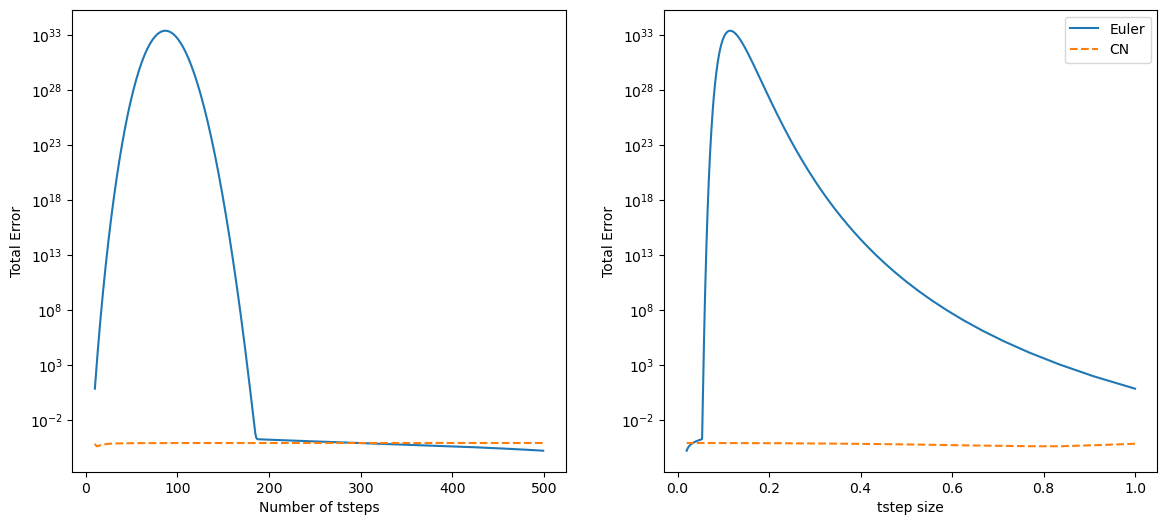

In [14]:
#Repeat for tstep variation
error_EE = []
error_CN = []

Nx=200
Nrange = np.arange(10,500,1)
for i in (Nrange): #Range of Nt to test
  Nt=i
  #Redefine and rerun functions
  t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
  x = np.linspace(x_start, x_end, Nx)  # Create a vector for x
  c_EE = EE(x, t, kappa); # explicit Euler
  c_CN = CN(x, t, kappa); # Crank-Nicolson

  abs_diff_EE = np.abs(diff_exact(x,kappa,20)-c_EE[:,-1]) #Getting absolute difference of exact & numerical as f(x)
  abs_diff_CN = np.abs(diff_exact(x,kappa,20)-c_CN[:,-1])

  #Sum these values to give total error per grid for specific grid spacing, added to our empty array
  error_EE = np.append(error_EE, np.sum(abs_diff_EE)/Nx)
  error_CN = np.append(error_CN, np.sum(abs_diff_CN)/Nx)


#Plot error as a function of tstep size
delta_t =t_end/Nrange
plt.figure

#Plotting error variation with number of xsteps
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(Nrange, error_EE,'C0-' ,label = 'Euler')
plt.plot(Nrange, error_CN,'C1--', label = 'CN')
plt.xlabel('Number of tsteps')
plt.ylabel('Total Error')
plt.yscale("log")

#Plotting error variation with xstep size
plt.subplot(1, 2, 2)
plt.plot(delta_t, error_EE,'C0-' ,label = 'Euler')
plt.plot(delta_t, error_CN,'C1--', label = 'CN')
plt.yscale("log")
plt.xlabel('tstep size')
plt.ylabel('Total Error')
plt.legend()
plt.show()

Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

INSERT DISCUSSION OF ERROR HERE (~1 paragraph).  OPTIONALLY ADD PLOTS BY INSERTING A CODE BLOCK BELOW.



**Error high for low values of dx due to instability of Euler method. Point for Euler error = 0 where there is perfect match as the computational curve crosses the exact solution curve. Blowup of error for Euler at rougly Nsteps = 60-120????. For a given error tolerance, Crank-Nicolson and explicit Euler have very similar error for a given Δx,with Euler resulting in slightly lower values. The error for Euler is also lower for any timestep size below ~0.055 for the above diffusivity and xstep size.
Euler reaches it's solutions faster than Crank Nicolson, with lower errors for most values of x&t stepsize and is in general more efficient. However, the instability of Euler gives it massive error for some regions of tstep size, in the above example anything above than Δt = 0.055 **

Now, move to Project1_dedalus.ipynb which will introduce Dedalus and spectral methods.

### 3. Optional further investigations

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This ensures that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?